# 01. Neural Network Regression with TensorFlow


## Typical architecture of a regresison neural network


| **Hyperparameter** | **Typical value** |
| --- | --- |
| Input layer shape | Same shape as number of features (e.g. 3 for # bedrooms, # bathrooms, # car spaces in housing price prediction) |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited |
| Neurons per hidden layer | Problem specific, generally 10 to 100 |
| Output layer shape | Same shape as desired prediction shape (e.g. 1 for house price) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) |
| Output activation | None, ReLU, logistic/tanh |
| Loss function | [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (mean square error) or [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error)/Huber (combination of MAE/MSE) if outliers |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) |

***Table 1:*** *Typical architecture of a regression network.* ***Source:*** *Adapted from page 293 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*



## How to improve a model

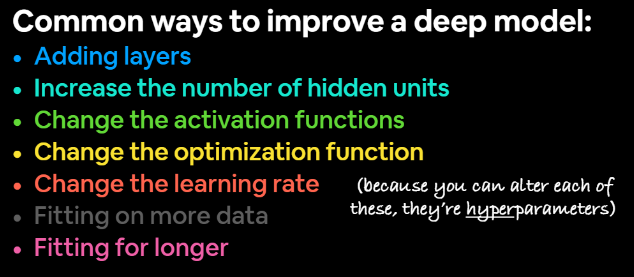

In [18]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import tensorflow as tf

print(tf.__version__)

2.8.0


## Base de dados Auto MPG

A base de dados está disponível  em [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


In [2]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
print("File path:", dataset_path)

40960/30286 [========================================] - 0s 2us/step
File path: /root/.keras/datasets/auto-mpg.data


In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model_Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model_Year      0
Origin          0
dtype: int64

In [5]:
dataset = dataset.dropna()

A coluna "Origin" representa os países de origem do veículo

In [6]:
dict_origin = {1:"USA", 2:"Europe", 3:"Japan"}
dataset["Origin"] = dataset["Origin"].map(dict_origin)

### Inspecione o dado

Dê uma rápida olhada em como está a distribuição de algumas colunas do conjunto de treinamento.

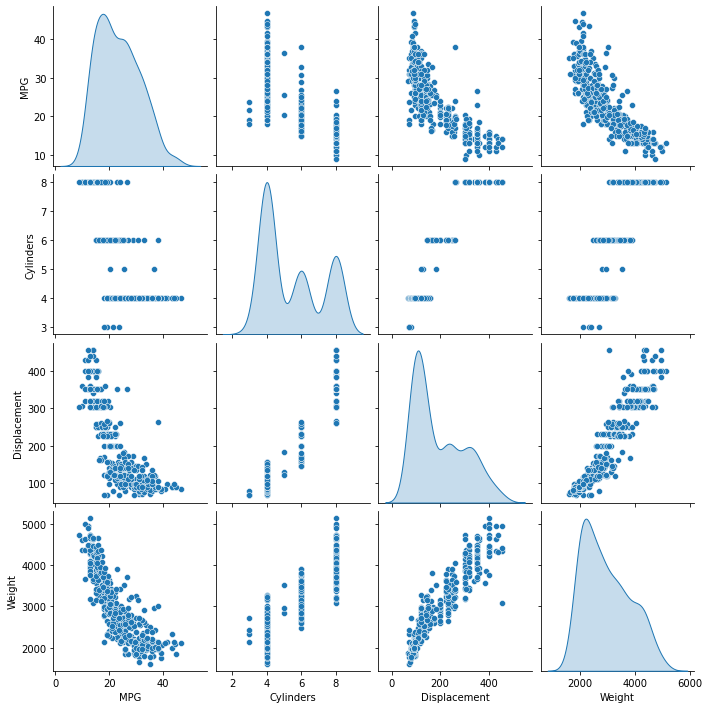

In [7]:
sns.pairplot(dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Repare na visão geral das estatísticas:

In [8]:
train_stats = dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MPG,392.0,23.445918,7.805007,9.0,17.000,22.75,29.000,46.6
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.00,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.00,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.50,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.50,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.50,17.025,24.8
Model_Year,392.0,75.979592,3.683737,70.0,73.000,76.00,79.000,82.0


### Normalize os dados


In [9]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

target = ["MPG"]

continuous_columns = ["Displacement", "Horsepower", "Weight", "Acceleration"]
categorical_columns = ["Model_Year", "Cylinders", "Origin"]
# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), continuous_columns), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse=False), categorical_columns)
)

# Create X & y
X = dataset.drop(target, axis=1)
y = dataset[target]

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

In [11]:
print("X_train",X_train_normal.shape, "Type", type(X_train_normal))
print("X_test",X_test_normal.shape, "Type", type(X_test_normal))

X_train (313, 25) Type <class 'numpy.ndarray'>
X_test (79, 25) Type <class 'numpy.ndarray'>


In [12]:
ct.get_feature_names_out()

array(['minmaxscaler__Displacement', 'minmaxscaler__Horsepower',
       'minmaxscaler__Weight', 'minmaxscaler__Acceleration',
       'onehotencoder__Model_Year_70', 'onehotencoder__Model_Year_71',
       'onehotencoder__Model_Year_72', 'onehotencoder__Model_Year_73',
       'onehotencoder__Model_Year_74', 'onehotencoder__Model_Year_75',
       'onehotencoder__Model_Year_76', 'onehotencoder__Model_Year_77',
       'onehotencoder__Model_Year_78', 'onehotencoder__Model_Year_79',
       'onehotencoder__Model_Year_80', 'onehotencoder__Model_Year_81',
       'onehotencoder__Model_Year_82', 'onehotencoder__Cylinders_3',
       'onehotencoder__Cylinders_4', 'onehotencoder__Cylinders_5',
       'onehotencoder__Cylinders_6', 'onehotencoder__Cylinders_8',
       'onehotencoder__Origin_Europe', 'onehotencoder__Origin_Japan',
       'onehotencoder__Origin_USA'], dtype=object)

In [13]:
#Converter para DataFrame
X_train_normal = pd.DataFrame(X_train_normal, columns=ct.get_feature_names_out())
X_test_normal = pd.DataFrame(X_test_normal, columns=ct.get_feature_names_out())

In [19]:
X_train_normal.head()

,minmaxscaler__Displacement,minmaxscaler__Horsepower,minmaxscaler__Weight,minmaxscaler__Acceleration,onehotencoder__Model_Year_70,onehotencoder__Model_Year_71,onehotencoder__Model_Year_72,onehotencoder__Model_Year_73,onehotencoder__Model_Year_74,onehotencoder__Model_Year_75,...,onehotencoder__Model_Year_81,onehotencoder__Model_Year_82,onehotencoder__Cylinders_3,onehotencoder__Cylinders_4,onehotencoder__Cylinders_5,onehotencoder__Cylinders_6,onehotencoder__Cylinders_8,onehotencoder__Origin_Europe,onehotencoder__Origin_Japan,onehotencoder__Origin_USA
0,0.40,0.35,0.57,0.64,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
1,0.18,0.25,0.27,0.41,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2,0.26,0.28,0.39,0.39,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
3,0.64,0.57,0.72,0.33,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
4,0.04,0.10,0.07,0.50,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


# Baseline Model

In [15]:
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, SGDRegressor, ElasticNet,LogisticRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures

In [28]:
df_results = pd.DataFrame(columns=['Modelo', 'R2', "mean_absolute_error","rmse", "mean_squared_error"])

model_xgb = XGBRegressor(colsample_bytree=0.7, 
                          #gamma=0.0468,
                          learning_rate=0.05, 
                          max_depth=3,
                          #min_child_weight=2.0, 
                          n_estimators=200,
                          reg_alpha=0.5, 
                          reg_lambda=0.88,
                          subsample=1,
                          random_state=8, 
                          nthread = -1
                        )

regressores = {
    'XGBRegressor': XGBRegressor(learning_rate=0.05,max_depth=5, n_estimators=200)
    ,'Lasso': Lasso(alpha=0.0005,random_state=8)
    #,'SGDRegressor': SGDRegressor(random_state=8)
    ,'ElasticNet': ElasticNet(alpha=0.0005,random_state=8)
    ,'GradientBoosting': GradientBoostingRegressor(learning_rate=0.04,n_estimators=100,random_state=8)
    ,'Ridge': Ridge( solver="cholesky",random_state=8)
    ,'AdaBoostRegressor': AdaBoostRegressor(n_estimators=500,learning_rate=0.05,random_state=8)
    #,'CatBoostRegressor': CatBoostRegressor(iterations=200,learning_rate=0.05,depth=2,l2_leaf_reg= 0.2,verbose=False,random_state=8)
}

modelos_treinados = {}

for no_modelo, modelo in regressores.items():
  dict_result = {}
  my_pipeline = Pipeline(
      steps=[
              ('model', modelo)
      ]
  )

  model_to_deploy = my_pipeline.fit(X_train_normal, y_train)

  #Calcular dados de treino
  y_pred = my_pipeline.predict(X_test_normal)

  dict_result['Modelo'] = no_modelo
  dict_result['R2'] = r2_score(y_test, y_pred)
  dict_result["mean_absolute_error"] = mean_absolute_error(y_test, y_pred)
  dict_result["rmse"] = np.sqrt(mean_squared_error(y_test, y_pred))
  dict_result["mean_squared_error"] = mean_squared_error(y_test, y_pred)

  df_results = df_results.append(dict_result, ignore_index=True)

[11:52:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [29]:
df_results.sort_values('mean_absolute_error', ascending=True)

,Modelo,R2,mean_absolute_error,rmse,mean_squared_error
1,Lasso,0.87,1.95,2.59,6.69
2,ElasticNet,0.87,1.95,2.59,6.73
0,XGBRegressor,0.83,2.03,2.95,8.69
4,Ridge,0.86,2.04,2.67,7.11
3,GradientBoosting,0.79,2.37,3.28,10.78
5,AdaBoostRegressor,0.71,2.92,3.82,14.61


# Modeling a Neural Network

In [61]:
# Set random seed
tf.random.set_seed(42)

# Add an extra layer and increase number of units
model = tf.keras.Sequential([
  tf.keras.layers.Dense(100, activation="relu"),
  #tf.keras.layers.Dense(75, activation="relu"),
  #tf.keras.layers.Dense(25, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1, activation="relu")
])

# Compile the model
model.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(lr=0.001),
                          #optimizer=tf.keras.optimizers.RMSprop(),
                          metrics=['mae'])

#Verificar o melhor Learning rate
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20)) 

# O parâmetro patience é o quantidade de epochs para checar as melhoras
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

# Callback to save the best weights during training process
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Fit the model and save the history (we can plot this)
history = model.fit(X_train_normal,
                                y_train,
                                epochs=600,
                                validation_data=(X_test_normal, y_test),
                                # Callbacks: Checkpoint: Model weights are saved at the end of every epoch, if it's the best seen
                                callbacks=[model_checkpoint_callback, early_stop],
                                verbose=0)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

In [62]:
model.evaluate(X_test_normal, y_test)

3/3 [==============================] - 0s 4ms/step - loss: 1.6778 - mae: 1.6778


[1.677843689918518, 1.677843689918518]

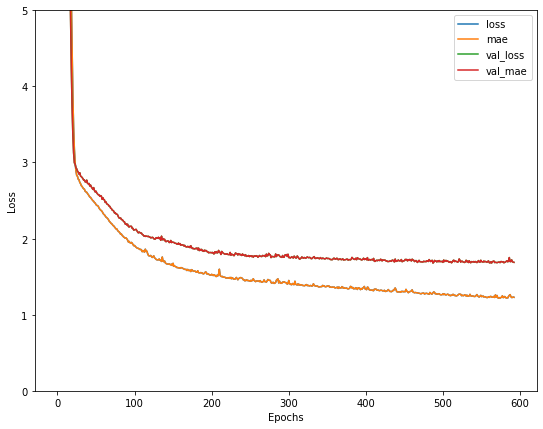

In [63]:
pd.DataFrame(history.history).plot(figsize=(9,7))
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.ylim(0,5);

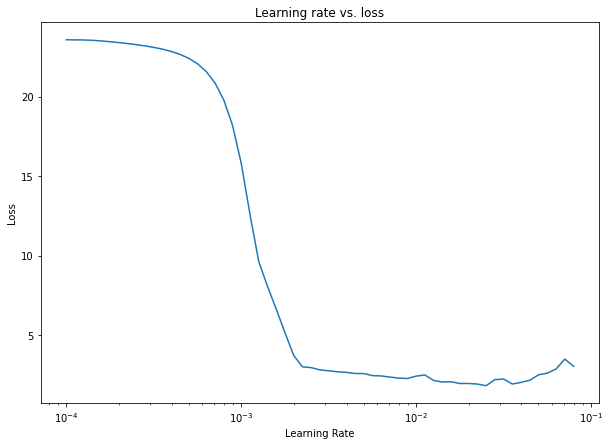

In [39]:
# Plot the learning rate versus the loss
epochs = len(history.history["loss"])
lrs = 1e-4 * (10 ** (np.arange(epochs)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

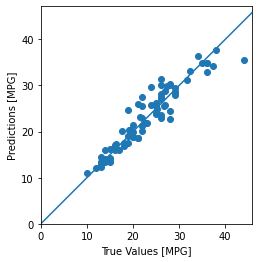

In [59]:
test_predictions = model.predict(X_test_normal).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


Parece que o nosso modelo prediz razoavelmente bem. Vamos dar uma olhada na distribuição dos erros.

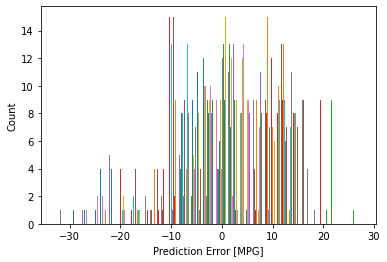

In [60]:
error = test_predictions - y_test.to_numpy()
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Não é tão gaussiana, porém podemos esperar que por conta do número de exemplo é bem pequeno.